Comparison of Optimization Algorithms for Total Variation Denoising
===================================================================

This example compares the performance of ADMM, Linearized ADMM, and PDHG
in solving the isotropic total variation (TV) denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is the isotropic TV: the sum of the norms of the gradient
vectors at each point in the image $\mathbf{x}$.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.optimize import PDHG, LinearizedADMM
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Add noise to create a noisy test image.

In [3]:
σ = 1.0  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Construct operators and functionals and set regularization parameter.

In [4]:
# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
f = loss.SquaredL2Loss(y=y)
λ = 1e0
g = λ * functional.L21Norm()

For reasons that are not entirely clear, the first step of the first-run
solver is much slower than the following steps. Perform a preliminary
solver step, the result of which is discarded, to avoid this bias in the
timing results.

In [5]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=1,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 1}),
)
solver_admm.solve();  # fmt: skip
# trailing semi-colon suppresses output in notebook

Solve via ADMM with a maximum of 2 CG iterations.

In [6]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=200,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 2}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
solver_admm.solve()
hist_admm = solver_admm.itstat_object.history(transpose=True)

Solving on CPU

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  9.49e-02  1.087e+05  2.558e+01  5.289e+01      0  4.326e-08
  10  1.95e-01  6.892e+04  1.857e+00  3.876e+01      2  7.503e-03


  20  2.71e-01  4.835e+04  1.899e+00  2.614e+01      2  1.170e-02
  30  3.47e-01  3.964e+04  1.546e+00  1.607e+01      2  1.619e-02


  40  4.22e-01  3.656e+04  1.140e+00  9.024e+00      2  1.831e-02
  50  4.97e-01  3.565e+04  9.100e-01  4.568e+00      2  1.626e-02
  60  5.72e-01  3.539e+04  5.862e-01  2.480e+00      2  1.223e-02


  70  6.50e-01  3.530e+04  3.650e-01  1.409e+00      2  8.386e-03
  80  7.25e-01  3.527e+04  2.217e-01  8.554e-01      2  5.367e-03
  90  7.98e-01  3.526e+04  1.380e-01  5.328e-01      2  3.427e-03


 100  8.73e-01  3.526e+04  8.452e-02  3.462e-01      2  2.147e-03
 110  9.46e-01  3.526e+04  5.323e-02  2.325e-01      2  1.342e-03
 120  1.02e+00  3.525e+04  3.648e-02  1.557e-01      2  8.514e-04


 130  1.12e+00  3.525e+04  2.413e-02  1.088e-01      2  5.531e-04
 140  1.20e+00  3.525e+04  1.743e-02  7.768e-02      2  3.613e-04


 150  1.28e+00  3.525e+04  1.364e-02  5.588e-02      2  2.420e-04
 160  1.36e+00  3.525e+04  1.128e-02  4.088e-02      2  1.670e-04


 170  1.45e+00  3.525e+04  9.578e-03  2.966e-02      2  1.167e-04
 180  1.52e+00  3.525e+04  8.462e-03  2.193e-02      2  8.459e-05
 190  1.59e+00  3.525e+04  7.851e-03  1.574e-02      2  7.817e-05


 199  1.65e+00  3.525e+04  7.156e-03  1.146e-02      1  9.794e-05


Solve via Linearized ADMM.

In [7]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=1e-2,
    nu=1e-1,
    x0=y,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  5.11e-02  1.087e+05  2.558e+01  5.289e+01
  10  9.13e-02  8.917e+04  9.516e-01  2.399e+01
  20  1.29e-01  7.244e+04  1.057e+00  1.900e+01
  30  1.64e-01  6.075e+04  1.088e+00  1.478e+01


  40  2.00e-01  5.273e+04  1.055e+00  1.141e+01
  50  2.34e-01  4.727e+04  9.935e-01  8.829e+00


  60  2.67e-01  4.355e+04  9.018e-01  6.873e+00
  70  3.00e-01  4.102e+04  7.858e-01  5.381e+00
  80  3.33e-01  3.929e+04  6.943e-01  4.231e+00
  90  3.71e-01  3.810e+04  6.228e-01  3.350e+00


 100  4.09e-01  3.728e+04  5.452e-01  2.677e+00
 110  4.46e-01  3.671e+04  4.830e-01  2.147e+00


 120  4.79e-01  3.632e+04  4.221e-01  1.741e+00
 130  5.12e-01  3.604e+04  3.548e-01  1.417e+00
 140  5.48e-01  3.584e+04  3.086e-01  1.167e+00


 150  5.87e-01  3.569e+04  2.628e-01  9.672e-01
 160  6.25e-01  3.558e+04  2.260e-01  8.030e-01


 170  6.64e-01  3.551e+04  1.951e-01  6.740e-01
 180  6.98e-01  3.545e+04  1.699e-01  5.664e-01
 190  7.31e-01  3.540e+04  1.466e-01  4.813e-01
 199  7.62e-01  3.537e+04  1.265e-01  4.172e-01


Solve via PDHG.

In [8]:
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=4e-1,
    sigma=4e-1,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  5.99e-02  5.536e+04  2.118e+02  2.923e+02


  10  1.08e-01  3.687e+04  8.880e+00  1.540e+01
  20  1.41e-01  3.585e+04  2.550e+00  6.817e+00
  30  1.73e-01  3.558e+04  1.145e+00  4.096e+00
  40  2.06e-01  3.547e+04  6.492e-01  2.847e+00
  50  2.39e-01  3.541e+04  4.219e-01  2.153e+00
  60  2.70e-01  3.537e+04  2.954e-01  1.715e+00


  70  3.02e-01  3.535e+04  2.210e-01  1.414e+00
  80  3.35e-01  3.534e+04  1.670e-01  1.204e+00
  90  3.68e-01  3.532e+04  1.361e-01  1.038e+00
 100  3.99e-01  3.531e+04  1.164e-01  9.023e-01
 110  4.32e-01  3.531e+04  9.387e-02  7.948e-01
 120  4.67e-01  3.530e+04  7.800e-02  7.121e-01


 130  5.02e-01  3.530e+04  6.576e-02  6.443e-01
 140  5.39e-01  3.529e+04  5.890e-02  5.865e-01
 150  5.75e-01  3.529e+04  5.096e-02  5.372e-01
 160  6.10e-01  3.529e+04  4.431e-02  4.947e-01
 170  6.45e-01  3.528e+04  3.957e-02  4.587e-01


 180  6.83e-01  3.528e+04  3.615e-02  4.267e-01


 190  7.18e-01  3.528e+04  3.217e-02  3.995e-01
 199  7.50e-01  3.528e+04  2.968e-02  3.773e-01


Plot results. It is worth noting that:

1. PDHG outperforms ADMM both with respect to iterations and time.
2. ADMM greatly outperforms Linearized ADMM with respect to iterations.
3. ADMM slightly outperforms Linearized ADMM with respect to time. This is
   possible because the ADMM $\mathbf{x}$-update can be solved relatively
   cheaply, with only 2 CG iterations. If more CG iterations were required,
   the time comparison would be favorable to Linearized ADMM.

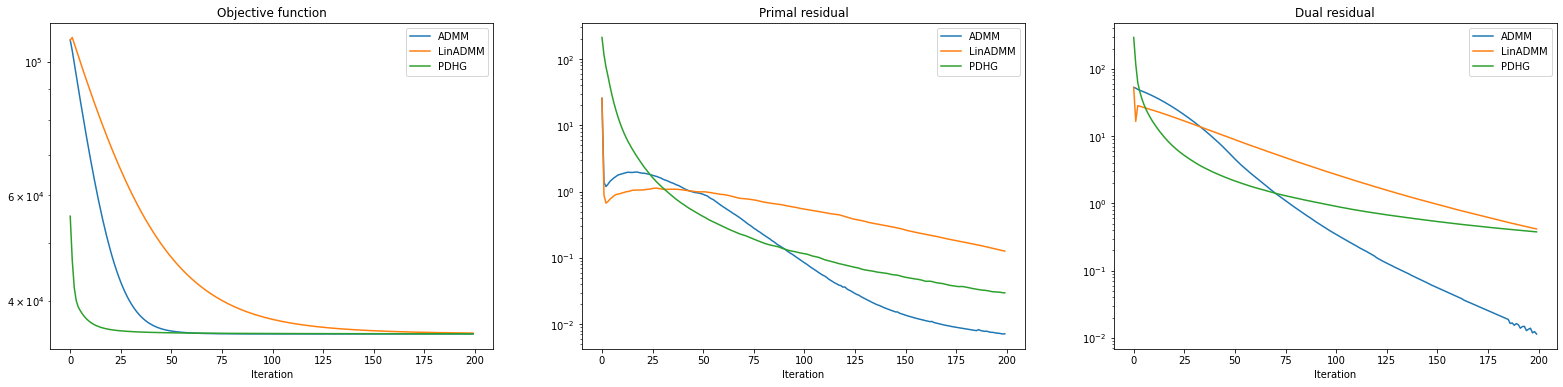

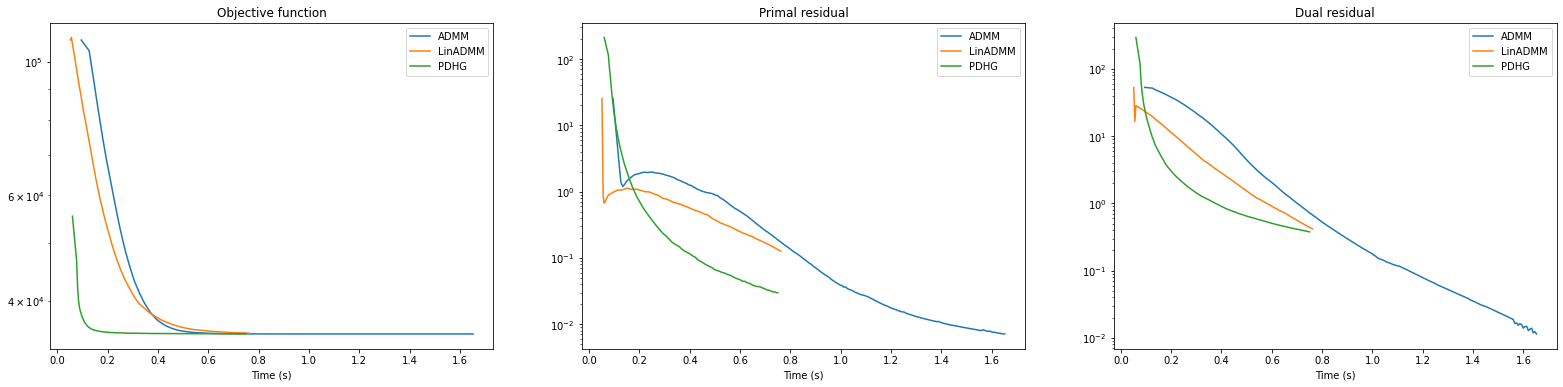

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()